In [78]:
import argparse
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

from mne.viz.topomap import _prepare_topo_plot, plot_topomap
import mne
from mne.channels import read_layout

from mpl_toolkits.axes_grid1 import make_axes_locatable

def main ():
    BoardShim.enable_board_logger()
    # use synthetic board for demo
    params = BrainFlowInputParams ()
    board = BoardShim (BoardIds.SYNTHETIC_BOARD.value, params)
    board.prepare_session ()
    board.start_stream ()
    time.sleep (10)
    data = board.get_current_board_data (1000) # get 20 latest data points dont remove them from internal buffer
    board.stop_stream ()
    board.release_session ()
    
    # demo how to convert it to pandas DF and plot data
    eeg_channels = BoardShim.get_eeg_channels (BoardIds.SYNTHETIC_BOARD.value)
    eeg_data = data[eeg_channels, :]
    
    # Creating MNE objects from brainflow data arrays
    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
    ch_names = ['T7', 'CP5', 'FC5', 'C3', 'C4', 'FC6', 'CP6', 'T8']
    sfreq = board.get_sampling_rate (BoardIds.SYNTHETIC_BOARD.value)
    info = mne.create_info (ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray (eeg_data, info)
    raw.plot (n_channels=8, scalings='auto', title='Raw Data',
          show=True, block=True)
    # filter over 1 - 50 Hz
    raw_filter = raw.copy ().filter (1, 2, n_jobs=1, fir_design='firwin')
    raw_filter.plot (n_channels=8, scalings='auto', title='Filtered Data',
          show=True, block=True)
    
    # if events array available
    event_id = 1
    events = np.array ([[100, 0, event_id],
                      [400, 0, event_id],
                      [700, 0, event_id]])
    epochs = mne.Epochs (raw_filter, tmin=-0.2, tmax=1.0, events=events, event_id=event_id, baseline=None)
    epochs.plot (scalings='auto', show=True, block=True, title="Epochs")
    
    # topograph
    layout = read_layout ('biosemi')
    _,epos,_,_,_ = _prepare_topo_plot (epochs,'eeg',layout)
    fig, ax_topo = plt.subplots (1, 1, figsize=(12, 4))
    title = "Topograph"
    data = raw_filter.get_data ()[:, 100] # plot the topograph at the 100th sample point
    img, _ = plot_topomap (data ,epos,show=True)

Creating RawArray with float64 data, n_channels=8, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 845 samples (3.301 sec)

3 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 3 events and 308 original time points ...
0 bad epochs dropped
Loading data for 3 events and 308 original time points ...
Loading data for 3 events and 308 original time points ...


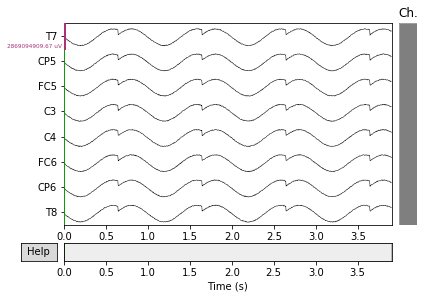

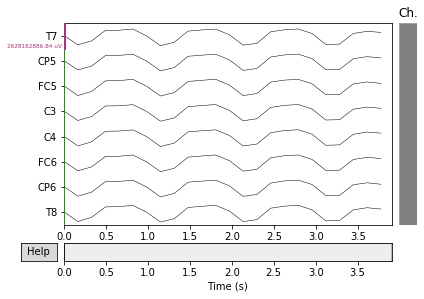

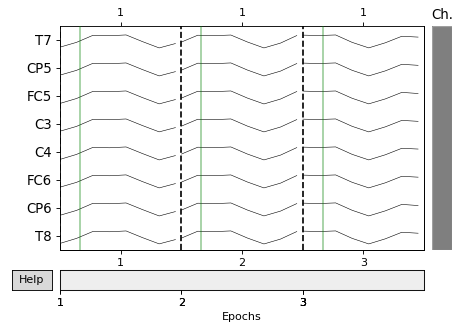

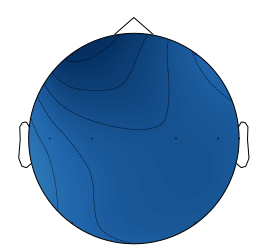

In [79]:
if __name__ == "__main__":
    main()

